# Configuración del entorno

In [14]:
# Preparar espacio de trabajo
import sys, os
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

mount_path = '/content/drive'
if not os.path.ismount(mount_path):
    drive.mount(mount_path)
else:
    print("Google Drive ya está montado.")
%cd /content/drive/MyDrive/IA-DeteccionFraude

# Red neuronal creada y preprocesamiento
sys.path.append(os.path.abspath("src"))
from neural_network import NeuralNetwork

Google Drive ya está montado.
/content/drive/MyDrive/IA-DeteccionFraude


In [15]:
# Crear archivo de preprocesamiento
%%writefile src/data_preprocessing.py

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from typing import List, Tuple

def preprocess_data(df: pd.DataFrame, num_cols: List[str], cat_cols: List[str]) -> Tuple[np.ndarray, np.ndarray, StandardScaler, OneHotEncoder]:
    """
    Preprocesa un DataFrame para ser usado en la red neuronal.
    Aplica:
    - Estandarización a columnas numéricas.
    - One-Hot Encoding a columnas categóricas.
    - Combina las características en una matriz de NumPy.
    - Separa las etiquetas (fraude).
    """
    if df.empty:
        raise ValueError("El DataFrame de entrada no puede estar vacío.")

    scaler = StandardScaler()
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Preprocesar columnas numéricas
    X_num = scaler.fit_transform(df[num_cols])

    # Preprocesar columnas categóricas
    X_cat = encoder.fit_transform(df[cat_cols])

    # Combinar todas las características
    X = np.hstack([X_num, X_cat])
    y = df['fraude'].values.reshape(-1, 1)

    return X, y, scaler, encoder


Writing src/data_preprocessing.py


#  Aplicación del modelo al problema de fraude

In [16]:
# Detección de Fraudes

# Importamos el módulo de preprocesamiento que acabamos de crear.
from data_preprocessing import preprocess_data

# Cargar los datos sintéticos de la carpeta 'data'.
df = pd.read_csv('data/datos_sinteticos_fraude.csv')

# Definir las columnas numéricas y categóricas.
num_cols = ['monto', 'hora', 'n_transacciones_1h', 'tiempo_ultima_transaccion', 'score_riesgo']
cat_cols = ['pais', 'dispositivo']

# Preprocesar los datos para la red neuronal.
X, y, _, _ = preprocess_data(df, num_cols, cat_cols)

# Dividir el dataset en conjuntos de entrenamiento y prueba, manteniendo la proporción de la clase 'fraude'.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Entrenar la red neuronal para el problema de fraude
# La arquitectura se ajusta al número de características preprocesadas (X.shape[1]).
nn = NeuralNetwork(layers=[X.shape[1], 32, 16, 1], activations=['tanh', 'tanh', 'sigmoid'])
history = nn.train(X_train, y_train, epochs=300, learning_rate=0.05, verbose=True)

# Evaluación del modelo con un umbral estándar de 0.5.
print("\n--- Evaluación con Umbral = 0.5 ---")
metrics_standard = nn.get_performance_metrics(X_test, y_test, threshold=0.5)
print(f"Accuracy: {metrics_standard['accuracy']:.4f}")
print(f"Precision: {metrics_standard['precision']:.4f}")
print(f"Recall (Sensibilidad): {metrics_standard['recall']:.4f}")
print(f"F1-Score: {metrics_standard['f1_score']:.4f}")
print("Matriz de Confusión:\n", metrics_standard['confusion_matrix'])

[   1/300] loss=0.254886
[  30/300] loss=0.105860
[  60/300] loss=0.049890
[  90/300] loss=0.028461
[ 120/300] loss=0.018741
[ 150/300] loss=0.013592
[ 180/300] loss=0.010529
[ 210/300] loss=0.008546
[ 240/300] loss=0.007178
[ 270/300] loss=0.006188
[ 300/300] loss=0.005445

--- Evaluación con Umbral = 0.5 ---
Accuracy: 0.9990
Precision: 0.0000
Recall (Sensibilidad): 0.0000
F1-Score: 0.0000
Matriz de Confusión:
 [[9990    0]
 [  10    0]]


In [17]:
# Optimización del umbral y evaluación con métricas óptimas

# En problemas de fraude, el F1-Score es más relevante que la precisión.
print("\n--- Optimización del Umbral ---")
best_threshold, best_metrics = nn.threshold_optimization(X_test, y_test)

# Imprimir las mejores métricas encontradas.
print(f"Umbral óptimo: {best_threshold:.4f}")
print("Mejores métricas:")
print(f"Accuracy: {best_metrics['accuracy']:.4f}")
print(f"Precision: {best_metrics['precision']:.4f}")
print(f"Recall (Sensibilidad): {best_metrics['recall']:.4f}")
print(f"F1-Score: {best_metrics['f1_score']:.4f}")
print("Matriz de Confusión Óptima:\n", best_metrics['confusion_matrix'])


--- Optimización del Umbral ---
Umbral óptimo: 0.2100
Mejores métricas:
Accuracy: 0.9995
Precision: 1.0000
Recall (Sensibilidad): 0.5000
F1-Score: 0.6667
Matriz de Confusión Óptima:
 [[9990    0]
 [   5    5]]


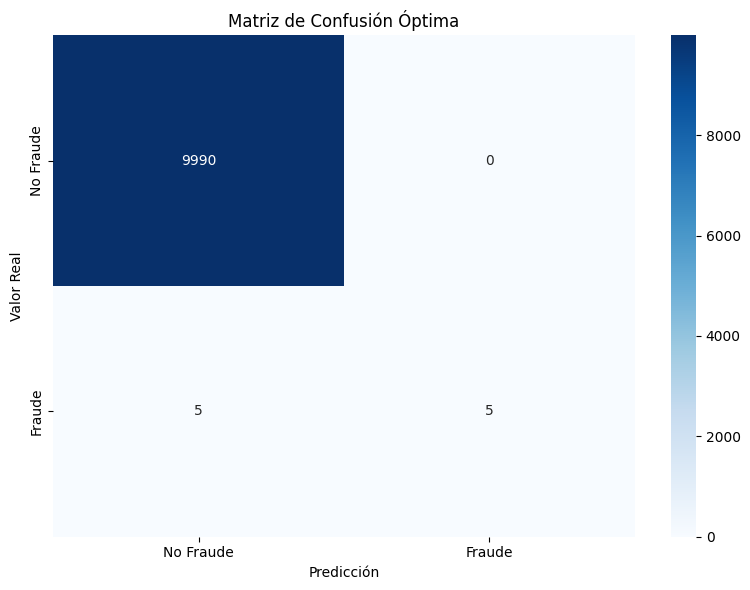

In [19]:
# Visualización y guardado de la matriz de confusión

# Generar la matriz de confusión con el umbral óptimo
y_pred_proba = nn.predict(X_test)
y_pred_binary_optimal = (y_pred_proba >= best_threshold).astype(np.int64)
cm_optimal = confusion_matrix(y_test, y_pred_binary_optimal)

# Crear un gráfico de calor para la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fraude', 'Fraude'],
            yticklabels=['No Fraude', 'Fraude'])
plt.title('Matriz de Confusión Óptima')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()

# Guardar el gráfico en la carpeta de resultados
plt.savefig('results/matriz_confusion_optima.png')
plt.show()

# Guardar los resultados del umbral óptimo en un archivo CSV
results_df = pd.DataFrame([best_metrics])
results_df.to_csv('results/metrics_optimal_threshold.csv', index=False)